Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## IMPORTS 

### Dataset

In [36]:
# import sys
# import platform

# print("--- Versão do Python e Módulos Nativos ---")
# # Módulos Nativos (não possuem __version__ próprio, usam a versão do Python)
# native_modules = ['zipfile', 'json', 're', 'asyncio']
# print(f"Python: {platform.python_version()}")
# print(f"Módulos Nativos (e.g., {', '.join(native_modules)}): Versão é a mesma do Python.")

# print("\n--- Versões de Bibliotecas de Terceiros ---")

# # Lista de bibliotecas para checar
# libraries_to_check = [
#     'numpy',
#     'pandas',
#     'scipy', # Checa scipy.sparse através do módulo pai scipy
#     'sklearn', # Checa sklearn e sklearn.model_selection
#     'implicit', # Checa implicit, implicit.als, implicit.bpr
#     'openai',
#     'matplotlib' # Exemplo de outra biblioteca comum
# ]

# for lib_name in libraries_to_check:
#     try:
#         # Importa a biblioteca dinamicamente
#         lib = __import__(lib_name)
        
#         # Acessa o atributo __version__ ou version
#         version = getattr(lib, '__version__', 'Versão não encontrada')
        
#         # Casos especiais onde a versão pode ser um sub-módulo
#         if lib_name == 'scipy':
#              print(f"{lib_name} (inclui scipy.sparse): {version}")
#         elif lib_name == 'sklearn':
#              print(f"{lib_name} (inclui sklearn.model_selection): {version}")
#         elif lib_name == 'implicit':
#              print(f"{lib_name} (inclui implicit.als e implicit.bpr): {version}")
#         else:
#             print(f"{lib_name:<15}: {version}")
        
#     except ImportError:
#         print(f"{lib_name:<15}: Não instalada")
#     except Exception as e:
#         print(f"{lib_name:<15}: Erro ao checar a versão ({e})")

In [134]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re


In [135]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

Loaded 10006 train conversations
Loaded 1342 test conversations


In [28]:
train_data[32]

{'movieMentions': {'127328': 'Hairspray  (2007)',
  '172129': 'Chicago 10  (2007)',
  '124268': 'Mamma Mia!  (2008)',
  '145997': 'Chicago  (2002)',
  '124461': 'White Christmas  (1954)',
  '107350': 'Sweeney Todd: The Demon Barber of Fleet Street  (2007)'},
 'respondentQuestions': {'127328': {'suggested': 0, 'seen': 1, 'liked': 1},
  '172129': {'suggested': 1, 'seen': 1, 'liked': 1},
  '124268': {'suggested': 1, 'seen': 0, 'liked': 1},
  '145997': {'suggested': 1, 'seen': 1, 'liked': 1},
  '124461': {'suggested': 1, 'seen': 1, 'liked': 1},
  '107350': {'suggested': 0, 'seen': 1, 'liked': 1}},
 'messages': [{'timeOffset': 0,
   'text': 'Hi can you help me find a musical',
   'senderWorkerId': 1,
   'messageId': 1575},
  {'timeOffset': 2,
   'text': 'hey what kind of movies interest you',
   'senderWorkerId': 14,
   'messageId': 1576},
  {'timeOffset': 13,
   'text': 'yes i would love to!',
   'senderWorkerId': 14,
   'messageId': 1577},
  {'timeOffset': 60,
   'text': 'I really like @1

In [27]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [ ]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "User 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "User 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
Usuário 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like Hairspray  (2007) too!
Usuário 2: oops, I meant Chicago  (2002)
Usuário 1: Yeah I have seen Chicago  (2002) many times
Usuário 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
Usuário 1: I have not seen Mamma Mia!  (2008) I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [6]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


In [7]:
#Filtrar outliers que assistiram muitos ou quase nenhum filmes?

## Tratamento e Limpeza dos datasets

In [136]:
def clean_data(dataset):
    """
    Remove diálogos inválidas do dataset 
    """

    invalid_indexes = []

    # Identifica diálogos inválidas
    for i, conv in enumerate(dataset):
        if (
            isinstance(conv.get("movieMentions"), list) # Se for lista em vez de dicionário
            or not isinstance(conv.get("movieMentions", {}), dict) # Se dicionário for inválido
            or "messages" not in conv # Diálogo sem mensagem
            or not conv["messages"] # Diálogo sem mensagem
        ):
            invalid_indexes.append(i)

    # Remove invalidos
    for i in sorted(invalid_indexes, reverse=True):
        del dataset[i]

    print(f"✅ Conversas válidas restantes: {len(dataset)}")
    print(f"🗑️ Conversas removidas: {len(invalid_indexes)}")

clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 1
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


## Extração de itens e Montagem Matriz Usuário-Item (LLM)

In [9]:
#!pip install openai
#!pip install implicit


### API LLM

In [ ]:
#!pip install python-dotenv

Defaulting to user installation because normal site-packages is not writeable


In [40]:
from dotenv import load_dotenv
import os

load_dotenv() 
API_KEY = os.getenv("API_KEY")


In [41]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI


client = OpenAI(api_key=API_KEY)
client_async = AsyncOpenAI(api_key=API_KEY)

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233

A vida é feita de momentos, aproveite cada um deles!


### Extração Itens

#### Funções 

In [ ]:
# Extração e atitude de user/item

# Formata cada dialogo de JSON para string, separando usuário de sistema 
def format_conversation(conv):

    """
    Formata cada dialogo de JSON para string, separando usuário de sistema 
    """

    msgs = []
    for msg in conv["messages"]:
        sender = "User" if msg["senderWorkerId"] == conv["initiatorWorkerId"] else "System"
        msgs.append(f"{sender}: {msg['text']}")
    return "\n".join(msgs)



def prompt_extraction_items(conv):

    """
    Gera o prompt que será enviado à LLM para extrair os filmes e atribuir ratings (1 a 5) apropriadas de acordo com a atitude do usuário.
    conversation_text = Dialogo
    mentioned_ids = IDs dos filmes mencionados
    filtered_mentions = Mantem apenas os IDs que aparecem na conversa 
    movie_mentions = String com o nome de filmes mencionados
    """

    conversation_text = format_conversation(conv)
    mentioned_ids = re.findall(r'@(\d+)', conversation_text)
    filtered_mentions = {k: v for k, v in conv["movieMentions"].items() if k in mentioned_ids}
    movie_mentions = "\n".join([f"@{k} = {v}" for k, v in filtered_mentions.items()])


#     prompt = f"""
# Pretend you are a movie recommender system. You (a
# recommender system) will be given a full conversation between a user
# and a system. Based on the entire conversation, you need to extract ALL 
# movie names mentioned and analyze the user's final attitude toward each movie.
# You need to reply with standardized movie names (with grammatical errors corrected 
# and abbreviations fixed), as well as the user's attitude toward the movie.


# Movies in the conversation are referred to by tokens like "@12345". The
# user's final attitude toward each movie is represented in one of 
# [1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
# negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
# very positive. You need to reply with the number as an attitude instead 
# of the textual description. If there are movie names mentioned in the query,
# list each movie name and the user's attitude (number in 0 to
# 5) in the form of movie_name####attitude, where different
# movies are listed in different lines with no extra sentences.
# Reply NO if no movie names are mentioned in the query.

# Use the following mapping to know which movie each token refers to:
# {movie_mentions}

# Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
# Do NOT include any other movies even if related or implied.
# If you include any movie not mentioned, your answer will be invalid.

# Conversation:
# {conversation_text}
# """

    prompt = f"""
Pretend you are a movie recommender system. You (a
recommender system) will be given a full conversation between a user
and a system. Based on the entire conversation, you need to extract ALL 
movie ids mentioned and analyze the user's final attitude toward each movie.
You need to reply with movie ids as well as the user's attitude toward the movie.


Movies in the conversation are referred to by tokens like "@12345". The
user's final attitude toward each movie is represented in one of 
[1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
very positive. You need to reply with the number as an attitude instead 
of the textual description. If there are movie ids mentioned in the query,
list each movie id and the user's attitude (number in 0 to
5) in the form of movie_id####attitude, where different
movies are listed in different lines with no extra sentences.
You must reply ONLY with movie IDs (e.g., 122159), not movie names.
You mus remove the "@" that comes in the beginning of the movie id.


Use the following to know which movie each token refers to:
{movie_mentions}

Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
Do NOT include any other movies even if related or implied.
If you include any movie not mentioned, your answer will be invalid.

Conversation:
{conversation_text}

Example output format:
122159####5
84779####4
"""
    return prompt.strip()



def extract_user_movie_rating(conv, llm_response):

    """
    Extrai userId, movieId e rating a partir da resposta da LLM
    """

    user_id = conv["initiatorWorkerId"]
    lines = llm_response.strip().splitlines()
    data = []

    for line in lines:
        if "####" in line:
            movie_id, rating = line.split("####")

            data.append({
                "userId": user_id,
                "movieId": int(movie_id.strip()),
                "rating": int(rating.strip())
            })

    return pd.DataFrame(data)


#### SYNC

In [31]:
# Testar com uma conversa
conv_35 = train_data[35]

# Montagem prompt extração item/rating
prompt = prompt_extraction_items(conv_35)

# Resposta LLM
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0
)

print("=== PROMPT ===")
print(prompt)

print("\n=== RESPOSTA ===")
print(response.choices[0].message.content.strip())


# Exemplo com resposta exemplo
llm_response = response.choices[0].message.content.strip()

# Extrai user/item/rating
df_result = extract_user_movie_rating(conv_35, llm_response)

print(df_result)

=== PROMPT ===
Pretend you are a movie recommender system. You (a
recommender system) will be given a full conversation between a user
and a system. Based on the entire conversation, you need to extract ALL 
movie ids mentioned and analyze the user's final attitude toward each movie.
You need to reply with movie ids as well as the user's attitude toward the movie.


Movies in the conversation are referred to by tokens like "@12345". The
user's final attitude toward each movie is represented in one of 
[1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
very positive. You need to reply with the number as an attitude instead 
of the textual description. If there are movie ids mentioned in the query,
list each movie id and the user's attitude (number in 0 to
5) in the form of movie_id####attitude, where different
movies are listed in different lines with no extra sentences.
You must reply ONLY with movie

#### ASYNC

In [12]:
# Execução Assíncrona

async def process_conversation(conv):

    """
    Processa um único diálogo
    """

    prompt = prompt_extraction_items(conv) # Gera prompt

    for attempt in range(3):  # tenta até 3 vezes
        try:
            # Chamada LLM
            response = await client_async.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )

            # Resosta LLM
            content = response.choices[0].message.content.strip()
            if content != "NO":
                return extract_user_movie_rating(conv, content) # Input para matriz usuário item com ratings
            break
        except Exception as e:
            await asyncio.sleep(2) 
    return pd.DataFrame(columns=["userId", "movieId", "rating"]) # Fallback


async def process_dataset(sample_data, batch_size=10):
    """
    Processa vários diálogos em paralelo (batch)
    """
    results = []
    for i in range(0, len(sample_data), batch_size): # Divide dataset em batches
        batch = sample_data[i:i+batch_size]
        tasks = [process_conversation(conv) for conv in batch] # Para cada diálogo no batch, calcula input da matriz
        batch_results = await asyncio.gather(*tasks) # Garante execução em paralelo 
        await asyncio.sleep(2) # evita timeout
        results.extend(batch_results)
        print(f" Processados {i+len(batch)} diálogos")

    df_all = pd.concat(results, ignore_index=True)
    return df_all #Matriz usuário item com ratings



In [13]:
user_item_train = await process_dataset(train_data, batch_size=40)


 Processados 40 diálogos
 Processados 80 diálogos
 Processados 120 diálogos
 Processados 160 diálogos
 Processados 200 diálogos
 Processados 240 diálogos
 Processados 280 diálogos
 Processados 320 diálogos
 Processados 360 diálogos
 Processados 400 diálogos
 Processados 440 diálogos
 Processados 480 diálogos
 Processados 520 diálogos
 Processados 560 diálogos
 Processados 600 diálogos
 Processados 640 diálogos
 Processados 680 diálogos
 Processados 720 diálogos
 Processados 760 diálogos
 Processados 800 diálogos
 Processados 840 diálogos
 Processados 880 diálogos
 Processados 920 diálogos
 Processados 960 diálogos
 Processados 1000 diálogos
 Processados 1040 diálogos
 Processados 1080 diálogos
 Processados 1120 diálogos
 Processados 1160 diálogos
 Processados 1200 diálogos
 Processados 1240 diálogos
 Processados 1280 diálogos
 Processados 1320 diálogos
 Processados 1360 diálogos
 Processados 1400 diálogos
 Processados 1440 diálogos
 Processados 1480 diálogos
 Processados 1520 diálogos


In [25]:
user_item_train.to_csv("user_item_train.csv", index=False, sep=";")
user_item_train

,userId,movieId,rating
0,0,84779,4
1,0,191602,4
2,0,122159,4
3,0,151313,4
4,0,203371,4
...,...,...,...
31814,953,204974,5
31815,954,85036,4
31816,954,170277,4
31817,954,149938,3


In [15]:
user_item_test = await process_dataset(test_data, batch_size=30)


 Processados 30 diálogos
 Processados 60 diálogos
 Processados 90 diálogos
 Processados 120 diálogos
 Processados 150 diálogos
 Processados 180 diálogos
 Processados 210 diálogos
 Processados 240 diálogos
 Processados 270 diálogos
 Processados 300 diálogos
 Processados 330 diálogos
 Processados 360 diálogos
 Processados 390 diálogos
 Processados 420 diálogos
 Processados 450 diálogos
 Processados 480 diálogos
 Processados 510 diálogos
 Processados 540 diálogos
 Processados 570 diálogos
 Processados 600 diálogos
 Processados 630 diálogos
 Processados 660 diálogos
 Processados 690 diálogos
 Processados 720 diálogos
 Processados 750 diálogos
 Processados 780 diálogos
 Processados 810 diálogos
 Processados 840 diálogos
 Processados 870 diálogos
 Processados 900 diálogos
 Processados 930 diálogos
 Processados 960 diálogos
 Processados 990 diálogos
 Processados 1020 diálogos
 Processados 1050 diálogos
 Processados 1080 diálogos
 Processados 1110 diálogos
 Processados 1140 diálogos
 Processad

In [23]:
user_item_test.to_csv("user_item_test.csv", index=False, sep=";")
user_item_test 

,userId,movieId,rating
0,956,111776,3
1,956,151656,4
2,956,192131,3
3,956,134643,3
4,956,94688,4
...,...,...,...
1721,1084,204870,4
1722,1084,95785,4
1723,1084,205724,4
1724,1084,90248,5


In [3]:
import pandas as pd
train_user_item = pd.read_csv("../data/user_item_train.csv", sep = ';')
test_user_item = pd.read_csv("../data/user_item_test.csv", sep = ';')


### DF certo

In [156]:
def extract_interactions_robust(conv):
    """
    Extrai TODAS as menções de filmes (movieMentions) como interações implícitas (rating=1).
    Isso alinha com o protocolo do KBRD/CRAG que tentam prever qualquer menção.
    """
    rows = []
    
    # Pegamos o ID do iniciador (geralmente o 'seeker' de recomendação)
    u_init = conv.get("initiatorWorkerId")
    
    # Dicionário de menções no texto da conversa (o ouro do dataset)
    mentions = conv.get("movieMentions", {})
    
    if u_init and isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # Interação Implícita: Se foi mencionado, é relevante para o contexto (Rating = 1)
                rows.append((u_init, int(movie_id_str), 1))
            except ValueError:
                continue
                
    return rows

def build_redial_interaction_df_robust(dataset):
    all_rows = []
    for conv in dataset:
        all_rows.extend(extract_interactions_robust(conv))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa, conta como 1)
    df = df.drop_duplicates()
    return df

# --- RE-GERAR DATAFRAMES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_redial_interaction_df_robust(train_data)
df_test = build_redial_interaction_df_robust(test_data)

print(f"Novas dimensões Treino: {df_train.shape}")
print(f"Novas dimensões Teste: {df_test.shape}")

Extraindo dados com metodologia Robusta (Menções)...
Novas dimensões Treino: (39053, 3)
Novas dimensões Teste: (5038, 3)


#### Filtrar por interações



In [157]:
# 1 — contar interações
movie_counts = df_train['movieId'].value_counts()

# 2 — selecionar os filmes "populares" (≥ 5 interações) 
popular_movies = movie_counts[movie_counts >= 6].index.tolist() 

# 3 — filtrar df_train
df_train_filtered = df_train[df_train['movieId'].isin(popular_movies)].copy()
df_test_filtered = df_test[df_test['movieId'].isin(popular_movies)].copy()



print(df_train_filtered.head())
print(df_train_filtered.shape)

print(df_test_filtered.head())
print(df_test_filtered.shape)

# userId  movieId  rating
# 0       0   203371       1
# 3       0   151313       1
# 5       0   165710       1
# 6       1   203371       1
# 9       1   151313       1
# (51430, 3)
#    userId  movieId  rating
# 0     956   111776       1
# 1     956   151656       1
# 2     956   134643       1
# 3     956   192131       1
# 5     957   111776       1
# (6250, 3)

   userId  movieId  rating
0       2   196336       1
3       2   114851       1
4       2   128905       1
6       2   152242       1
7       2   204292       1
(30604, 3)
   userId  movieId  rating
0     956   111776       1
1     956    91481       1
2     956   151656       1
3     956   134643       1
4     956   192131       1
(3735, 3)


### Matrix Factorization

In [158]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix



def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """
        Cria matriz esparsa a partir de DataFrame
        user_mapper e movie_mapper são dicionarios do mapeamento
    """

    df_mapped = df.copy()

    # Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
    
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix



In [159]:
#Utility matrix (user-item)

np.random.seed(42)

all_data = pd.concat([df_train_filtered, df_test_filtered]) # Concatena train + test para garantir que todos os IDs estejam mapeados

# user_mapper = {u: i for i, u in enumerate(all_data['userId'].unique())}
# movie_mapper = {m: i for i, m in enumerate(all_data['movieId'].unique())}

user_ids = sorted(all_data['userId'].unique())
movie_ids = sorted(all_data['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_user_item_sparse = create_sparse_matrix(df_train_filtered, user_mapper, movie_mapper, (n_users, n_movies))
test_user_item_sparse = create_sparse_matrix(df_test_filtered, user_mapper, movie_mapper, (n_users, n_movies))


train_item_user_sparse = train_user_item_sparse.T.tocsr()
test_item_user_sparse  = test_user_item_sparse.T.tocsr()








In [160]:
nonzero_cols = train_user_item_sparse[:10].nonzero()[1]
unique_cols = np.unique(nonzero_cols)

# pegar apenas os 6 primeiros filmes relevantes
selected_cols = unique_cols[:6]

# recorte da matriz
small_matrix = train_user_item_sparse[:10, selected_cols].toarray()

df_view = pd.DataFrame(
    small_matrix,
    columns=[f"Movie_{c}" for c in selected_cols],
    index=[f"User_{i}" for i in range(10)]
)

print(df_view)




        Movie_1  Movie_3  Movie_6  Movie_14  Movie_15  Movie_17
User_0      0.0      1.0      1.0       1.0       0.0       1.0
User_1      0.0      1.0      0.0       0.0       0.0       0.0
User_2      0.0      0.0      0.0       0.0       0.0       0.0
User_3      1.0      0.0      0.0       0.0       1.0       0.0
User_4      1.0      1.0      0.0       0.0       0.0       1.0
User_5      0.0      0.0      0.0       0.0       0.0       0.0
User_6      0.0      0.0      0.0       0.0       0.0       0.0
User_7      0.0      1.0      0.0       0.0       0.0       0.0
User_8      0.0      0.0      0.0       0.0       0.0       0.0
User_9      0.0      0.0      0.0       0.0       0.0       0.0


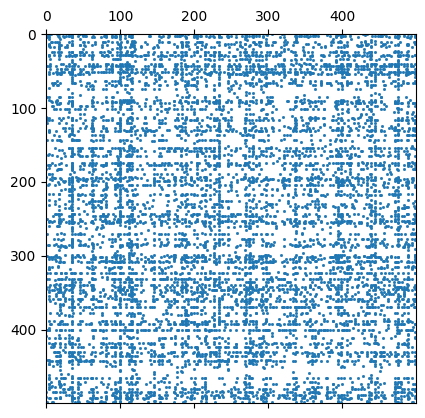

In [161]:
import matplotlib.pyplot as plt
plt.spy(train_user_item_sparse[:500, :500], markersize=1)
plt.show()


In [162]:
import numpy as np

def matrix_stats(M):


    print(f"Dimensões (usuários x itens): {M.shape}")
    print(f"Número total de elementos: {M.shape[0] * M.shape[1]:,}")
    
    # Elementos não nulos
    nnz = M.nnz

    # Densidade / Sparsidade
    density = nnz / (M.shape[0] * M.shape[1])
    print(f"Densidade: {density:.6f}")
    print(f"Esparsidade: {1 - density:.6f}")


    print(f"Média dos ratings: {M.data.mean():.2f}")


# Chamada:
matrix_stats(train_user_item_sparse)


Dimensões (usuários x itens): (761, 1505)
Número total de elementos: 1,145,305
Densidade: 0.026721
Esparsidade: 0.973279
Média dos ratings: 1.00


### Normalização (MEAN NORMALIZATION)

In [163]:
from sklearn.preprocessing import normalize
train_matrix_normalized = normalize(train_user_item_sparse, norm='l2', axis=1)
train_matrix_normalized

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 30604 stored elements and shape (761, 1505)>

## Treinamento Modelo

#### EASEr (Embarrassingly Shallow Autoencoders)

##### Treino

In [164]:


import numpy as np

class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_=0.5):
        """
        X: sparse matrix (users × items)
        lambda_: regularization
        """
        self.X = X
        G = (X.T @ X).toarray()

        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0

        self.B = B
        self.pred = X @ B

    def recommend(self, user, k=10):
        """
        user: índice inteiro
        retorna: top-k itens não consumidos
        """
        user_row = self.X[user].toarray().ravel()
        scores = self.pred[user]

        watched = np.where(user_row > 0)[0]
        scores[watched] = -np.inf

        topk = np.argpartition(scores, -k)[-k:]
        topk = topk[np.argsort(scores[topk])[::-1]]

        return topk, scores[topk]


In [165]:
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=0.5)

import numpy as np

def recommend_user(ease, user, k=10):
    # scores previstos para todos os itens
    scores = ease.pred[user].copy()

    # remover itens que o usuário já consumiu
    user_interactions = ease.X[user].toarray().ravel()
    scores[user_interactions > 0] = -np.inf

    # pegar top-k
    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]  # ordenar

    return topk, scores[topk]


items, scores = recommend_user(ease, user=0, k=10)
print(items)
print(scores)

[ 653 1047  647  270  703 1218  771 1426 1045  721]
[0.016197   0.01565097 0.01436932 0.01404051 0.01300975 0.01259805
 0.01153639 0.01031372 0.00992799 0.00984275]


##### Teste

In [166]:
import numpy as np

def evaluate_ease_foldin(ease_model, test_matrix, k=20, input_ratio=0.5, seed=42):
    """
    Avaliação Fold-in que retorna Recall@K e NDCG@K.
    """
    recalls = []
    ndcgs = []
    
    if seed is not None:
        np.random.seed(seed)
        
    n_users = test_matrix.shape[0]
    
    # Número de itens baseado no modelo treinado (para segurança dimensional)
    n_items_model = ease_model.B.shape[0] 
    
    # Copia matriz de pesos e zera diagonal
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)

    # Cache para cálculo do denominador do DCG (log2) para otimizar
    # Denominador: log2(2), log2(3), log2(4)... -> posições 1, 2, 3...
    discounts = np.log2(np.arange(k) + 2)

    for user_idx in range(n_users):
        
        # --- 1. Preparação dos Dados (Igual ao anterior) ---
        user_items = test_matrix[user_idx].indices
        
        # Filtra itens fora do range (segurança)
        user_items = user_items[user_items < n_items_model]

        # Precisamos de pelo menos 2 itens para dividir em Input/Target
        if len(user_items) < 2:
            continue

        np.random.shuffle(user_items)

        # Divisão Input / Target
        split_point = int(len(user_items) * input_ratio)
        split_point = max(1, min(len(user_items) - 1, split_point))

        input_items = user_items[:split_point]
        target_items = user_items[split_point:] # Ground Truth

        # --- 2. Predição Fold-In (Igual ao anterior) ---
        user_vector = np.zeros(n_items_model)
        user_vector[input_items] = 1.0

        scores = user_vector @ W
        scores[input_items] = -np.inf # Mascarar contexto

        # --- 3. Ranking (Crucial para NDCG) ---
        
        # Primeiro pegamos os índices não ordenados do Top-K (rápido)
        top_k_unsorted = np.argpartition(scores, -k)[-k:]
        
        # Agora pegamos os scores desses itens para ordenar corretamente
        top_k_scores = scores[top_k_unsorted]
        
        # argsort retorna ordem crescente, invertemos com [::-1] para decrescente
        sorted_idx = np.argsort(top_k_scores)[::-1]
        
        # IDs finais ordenados por score (do melhor para o pior)
        top_k_sorted = top_k_unsorted[sorted_idx]

        # --- 4. Cálculo das Métricas ---
        
        # Verifica interseção (Array de booleanos/binário: 1 se acertou, 0 se errou)
        # Ex: [1, 0, 0, 1, 1, ...]
        hits_mask = np.isin(top_k_sorted, target_items)
        
        # -- Recall --
        num_hits = np.sum(hits_mask)
        recall = num_hits / len(target_items)
        recalls.append(recall)
        
        # -- NDCG --
        # DCG: Soma dos hits ponderados pela posição logarítmica
        # Cortamos o vetor 'discounts' caso hits_mask seja menor que k (raro, mas possível)
        dcg = np.sum(hits_mask / discounts[:len(hits_mask)])
        
        # IDCG (Ideal DCG): O melhor cenário possível
        # No melhor caso, todos os itens relevantes estariam no topo da lista.
        # Quantos itens relevantes existem? len(target_items)
        # O IDCG considera preencher as primeiras posições com 1 até acabar os itens relevantes ou chegar em K.
        num_relevant_target = len(target_items)
        ideal_num = min(num_relevant_target, k)
        
        # O vetor ideal é [1, 1, 1... (até ideal_num)]
        idcg = np.sum(1.0 / discounts[:ideal_num])
        
        if idcg > 0:
            ndcgs.append(dcg / idcg)
        else:
            ndcgs.append(0.0)

    return np.mean(recalls), np.mean(ndcgs)

# === COMO RODAR ===

print("Calculando Métricas Corrigidas...")
recall_final, ndcg_final = evaluate_ease_foldin(ease, test_user_item_sparse, k=20, input_ratio=0.9)

print(f"==========================================")
print(f"Recall@20: {recall_final:.4f}")
print(f"NDCG@20:   {ndcg_final:.4f}")
print(f"==========================================")



#Recall@20: 0.1029
#Recall@20: 0.1686

Calculando Métricas Corrigidas...
Recall@20: 0.1855
NDCG@20:   0.0976


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- 1. CLASSE EASE (Seu Modelo) ---
class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_=500): # Aumentei lambda para lidar com mais dados
        print("Treinando EASE...")
        self.X = X
        G = (X.T @ X).toarray()
        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_
        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0
        self.B = B
        self.pred = X @ B
        print("Treinamento concluído.")

# # --- 2. EXTRAÇÃO DE DADOS CORRIGIDA ---
# def extract_interactions_robust(dataset):
#     """
#     Extrai TODAS as menções de filmes como interações implícitas.
#     Ignora a flag 'liked' para aumentar a densidade (Implicit Feedback).
#     """
#     all_rows = []
    
#     for conv in dataset:
#         u_init = conv.get("initiatorWorkerId")
#         # u_resp = conv.get("respondentWorkerId") # Focamos no usuário (initiator)
        
#         # Dicionário mestre de menções da conversa
#         mentions = conv.get("movieMentions", {})
        
#         if not u_init or not isinstance(mentions, dict):
#             continue
            
#         for movie_id_str, movie_name in mentions.items():
#             try:
#                 # Assumimos interação positiva implícita (1) pela menção
#                 # No ReDial, mencionar geralmente significa que viu ou gostou
#                 all_rows.append((u_init, int(movie_id_str), 1))
#             except ValueError:
#                 continue
                
#     return pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"]).drop_duplicates()

# # --- CARREGANDO DADOS ---
# # (Assumindo que os arquivos já estão descompactados na pasta ../data/)
# print("Carregando datasets...")
# train_data = []
# for line in open("../data/train_data.jsonl", "r"):
#     train_data.append(json.loads(line))

# test_data = []
# for line in open("../data/test_data.jsonl", "r"):
#     test_data.append(json.loads(line))

# # Extração
# df_train = extract_interactions_robust(train_data)
# df_test = extract_interactions_robust(test_data)

# print(f"Interações Treino (Original): {len(df_train)}")
# print(f"Interações Teste (Original): {len(df_test)}")

# # --- 3. FILTRAGEM E MAPEAMENTO ---
# # Filtra filmes muito raros (Ruído), mas mantém a cauda longa
# min_interactions = 5
# movie_counts = df_train['movieId'].value_counts()
# valid_movies = movie_counts[movie_counts >= min_interactions].index.tolist()

# df_train = df_train[df_train['movieId'].isin(valid_movies)].copy()
# df_test = df_test[df_test['movieId'].isin(valid_movies)].copy()

# # Mapeamento UNIFICADO (Crucial!)
# # Usamos apenas filmes/usuários que existem no mapeamento
# all_users = sorted(list(set(df_train['userId']) | set(df_test['userId'])))
# all_movies = sorted(valid_movies)

# user_mapper = {u: i for i, u in enumerate(all_users)}
# movie_mapper = {m: i for i, m in enumerate(all_movies)}

# print(f"Total Usuários: {len(user_mapper)}")
# print(f"Total Filmes: {len(movie_mapper)}")

# # --- 4. CRIAÇÃO DE MATRIZES ---
# def make_csr(df, u_map, m_map):
#     # Filtra IDs que não estão no mapper (caso haja discrepância no teste)
#     df = df[df['userId'].isin(u_map) & df['movieId'].isin(m_map)]
    
#     rows = df['userId'].map(u_map)
#     cols = df['movieId'].map(m_map)
#     data = np.ones(len(df)) # Implicit feedback = 1
    
#     return csr_matrix((data, (rows, cols)), shape=(len(u_map), len(m_map)))

# train_matrix = make_csr(df_train, user_mapper, movie_mapper)
# test_matrix = make_csr(df_test, user_mapper, movie_mapper)



# --- 6. AVALIAÇÃO NEXT-ITEM (Igual à do KBRD) ---
def evaluate_next_item_protocol(model, test_matrix, k=20):
    all_recalls = []
    all_ndcgs = []
    
    n_users = test_matrix.shape[0]
    W = model.B
    discounts = np.log2(np.arange(k) + 2)
    
    # Loop por usuários
    for u in tqdm(range(n_users), desc="Avaliando"):
        user_items = test_matrix[u].indices
        
        # Precisa de pelo menos 2 itens (1 contexto, 1 alvo)
        if len(user_items) < 2:
            continue
            
        # Simula ordem temporal (shuffle é o melhor que temos sem timestamp)
        np.random.seed(42 + u) # Seed determinística por usuário
        np.random.shuffle(user_items)
        
        # Contexto Acumulativo
        scores = np.zeros(W.shape[0])
        
        # "Cold Start" simulado: Começa com o primeiro item
        context_items = [user_items[0]]
        scores += W[user_items[0]] # Soma pesos do primeiro item
        
        # Itera do 2º item em diante (Target)
        for target_item in user_items[1:]:
            
            # --- Predição ---
            # Mascara itens já vistos (contexto)
            current_scores = scores.copy()
            current_scores[context_items] = -np.inf
            
            # Top-K
            # (Usamos argpartition para velocidade)
            top_k_unsorted = np.argpartition(current_scores, -k)[-k:]
            
            # --- Métricas ---
            # Hit Rate (Recall@K para 1 item)
            if target_item in top_k_unsorted:
                all_recalls.append(1.0)
                
                # NDCG Calculation
                # Ordena o top-k para achar o rank
                top_scores = current_scores[top_k_unsorted]
                sorted_idx = np.argsort(top_scores)[::-1]
                top_k_sorted = top_k_unsorted[sorted_idx]
                
                rank = np.where(top_k_sorted == target_item)[0][0]
                all_ndcgs.append(1.0 / discounts[rank])
            else:
                all_recalls.append(0.0)
                all_ndcgs.append(0.0)
            
            # --- Atualiza Contexto ---
            # O target atual vira contexto para o próximo
            scores += W[target_item]
            context_items.append(target_item)
            
    return np.mean(all_recalls), np.mean(all_ndcgs)


# Teste com Lambda maior e métricas completas
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=500) # Tente 500 ou 1000

# ease.fit(train_matrix, lambda_=1000) # Tente 500 ou 1000



print("Calculando Métricas Finais...")
r1, n1   = evaluate_next_item_protocol(ease, test_user_item_sparse, k=1)
r5, n5   = evaluate_next_item_protocol(ease, test_user_item_sparse, k=5)
r10, n10 = evaluate_next_item_protocol(ease, test_user_item_sparse, k=10)
r20, n20 = evaluate_next_item_protocol(ease, test_user_item_sparse, k=20)
r50, n50 = evaluate_next_item_protocol(ease, test_user_item_sparse, k=50)

# print("Calculando Métricas Finais...")
# r1, n1   = evaluate_next_item_protocol(ease, test_matrix, k=1)
# r10, n10 = evaluate_next_item_protocol(ease, test_matrix, k=10)
# r20, n20 = evaluate_next_item_protocol(ease, test_matrix, k=20)
# r50, n50 = evaluate_next_item_protocol(ease, test_matrix, k=50)

print("-" * 30)
print(f"Recall@1:  {r1:.4f}")
print(f"Recall@5:  {r5:.4f}")
print(f"Recall@10: {r10:.4f}") # Compare com 0.12-0.16 (KBRD)
print(f"Recall@20: {r20:.4f}") 
print(f"Recall@50: {r50:.4f}") # Compare com 0.28-0.33 (KBRD)
print("-" * 30)


print("-" * 30)
print(f"NDCGl@1: {n1:.4f}")
print(f"NDCG@5:  {n5:.4f}")
print(f"NDCG@10: {n10:.4f}") # Compare com 0.12-0.16 (KBRD)
print(f"NDCG@20: {n20:.4f}") 
print(f"NDCG@50: {n50:.4f}") # Compare com 0.28-0.33 (KBRD)
print("-" * 30)

# ------------------------------
# Recall@1:  0.0151
# Recall@5:  0.0462
# Recall@10: 0.0783
# Recall@20: 0.1275
# Recall@50: 0.2229
# ------------------------------
# ------------------------------
# NDCGl@1: 0.0151
# NDCG@5:  0.0302
# NDCG@10: 0.0405
# NDCG@20: 0.0528
# NDCG@50: 0.0716
# ------------------------------

Treinando EASE...
Treinamento concluído.
Calculando Métricas Finais...


Avaliando: 100%|██████████| 761/761 [00:00<00:00, 4660.12it/s]

------------------------------
Recall@1:  0.0118
Recall@5:  0.0459
Recall@10: 0.0770
Recall@20: 0.1204
Recall@50: 0.2281
------------------------------
------------------------------
NDCGl@1: 0.0118
NDCG@5:  0.0287
NDCG@10: 0.0387
NDCG@20: 0.0496
NDCG@50: 0.0709
------------------------------


#### ALS (Alternating Least Squares)

In [168]:


model = AlternatingLeastSquares( 
    factors=32,
    regularization=0.01,
    alpha=20,           # essencial!
    iterations=30,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
model.fit(train_item_user_sparse)

print("user factors:", model.user_factors.shape)
print("item factors:", model.item_factors.shape)


NameError: name 'AlternatingLeastSquares' is not defined

In [ ]:
real_user = 0
internal = int(user_mapper[real_user])

# CORRETO: Passa a matriz transposta (mesma orientação do treino)
user_items_col = train_item_user_sparse.tocsr()[internal, :]

items, scores = model.recommend(
    internal,
    user_items_col,
    N=10,
    filter_already_liked_items=True
)

print("Itens recomendados:", items)
print("Scores:", scores)

Itens recomendados: [630 316 778 550 181 134 806 421 412  74]
Scores: [1.2899176  1.118655   1.0230751  1.0157359  0.9969041  0.9787041
 0.974956   0.96979016 0.9611718  0.89814246]


In [ ]:
import numpy as np

def recall_at_k_single(model, train_item_user_sparse, test_matrix, user_internal, K=20):
    """Calcula o recall@K para UM usuário interno."""
    
    relevant_items = set(test_matrix[user_internal].indices)
    if len(relevant_items) == 0:
        return None  # usuário sem teste → ignorar

    # coluna item×user
    user_items_col = train_item_user_sparse.tocsr()[user_internal, :]

    rec_items, _ = model.recommend(
        user_internal,
        user_items_col,
        N=K,
        filter_already_liked_items=True
    )

    rec_set = set(rec_items)
    hits = rec_set & relevant_items

    recall = len(hits) / len(relevant_items)
    return recall


# ==============================
#  ENCONTRAR USUÁRIOS QUE TÊM TESTE
# ==============================
test_nonzero = test_user_item_sparse.getnnz(axis=1)
users_with_test_internal = np.where(test_nonzero > 0)[0]

print(f"Usuários com teste: {len(users_with_test_internal)}")


# ==============================
#  CALCULAR RECALL PARA TODOS
# ==============================
recalls = []
valid_users = []

for u in users_with_test_internal:
    r = recall_at_k_single(model, train_item_user_sparse, test_user_item_sparse, u, K=20)
    if r is not None:
        recalls.append(r)
        valid_users.append(u)

# ==============================
# ESTATÍSTICAS
# ==============================
recalls = np.array(recalls)

print("\n=========== MÉTRICAS GLOBAIS (Recall@20) ===========")
print(f"Usuários avaliados:            {len(recalls)}")
print(f"Recall médio:                  {recalls.mean():.4f}")
print(f"Recall mediano:                {np.median(recalls):.4f}")
print(f"Recall mínimo:                 {recalls.min():.4f}")
print(f"Recall máximo:                 {recalls.max():.4f}")
print(f"Usuários com recall > 0:       {np.sum(recalls > 0)}  ({100*np.mean(recalls>0):.1f}%)")
print("=====================================================\n")

# Opcional: mostrar os 10 melhores e piores
sorted_recalls = sorted(zip(valid_users, recalls), key=lambda x: x[1], reverse=True)

print("Top 10 maiores recalls:")
for u, r in sorted_recalls[:10]:
    print(f"user_internal={u}, recall={r:.4f}")

print("\nTop 10 menores recalls:")
for u, r in sorted_recalls[-10:]:
    print(f"user_internal={u}, recall={r:.4f}")


Usuários com teste: 144

=========== MÉTRICAS GLOBAIS (Recall@20) ===========
Usuários avaliados:            144
Recall médio:                  0.0113
Recall mediano:                0.0000
Recall mínimo:                 0.0000
Recall máximo:                 0.2500
Usuários com recall > 0:       40  (27.8%)

Top 10 maiores recalls:
user_internal=965, recall=0.2500
user_internal=1033, recall=0.1667
user_internal=922, recall=0.1250
user_internal=1009, recall=0.1250
user_internal=988, recall=0.0833
user_internal=1026, recall=0.0833
user_internal=914, recall=0.0769
user_internal=900, recall=0.0556
user_internal=1025, recall=0.0556
user_internal=1032, recall=0.0556

Top 10 menores recalls:
user_internal=1027, recall=0.0000
user_internal=1028, recall=0.0000
user_internal=1029, recall=0.0000
user_internal=1030, recall=0.0000
user_internal=1031, recall=0.0000
user_internal=1034, recall=0.0000
user_internal=1035, recall=0.0000
user_internal=1036, recall=0.0000
user_internal=1037, recall=0.0000
u

In [ ]:
# usuários internos com dados no teste
users_with_test_internal = np.where(test_user_item_sparse.getnnz(axis=1) > 0)[0]

# inverse mapper (índice interno → userId real)
inverse_user_mapper = {v: k for k, v in user_mapper.items()}

# converter internos → reais
users_with_test_real = [inverse_user_mapper[i] for i in users_with_test_internal]

print("Total usuários com teste:", len(users_with_test_real))
print("Primeiros 30 IDs reais com teste:", users_with_test_real[:30])


Total usuários com teste: 144
Primeiros 30 IDs reais com teste: [np.int64(956), np.int64(957), np.int64(958), np.int64(959), np.int64(960), np.int64(961), np.int64(962), np.int64(963), np.int64(964), np.int64(965), np.int64(967), np.int64(968), np.int64(969), np.int64(971), np.int64(972), np.int64(973), np.int64(974), np.int64(976), np.int64(977), np.int64(978), np.int64(979), np.int64(980), np.int64(981), np.int64(982), np.int64(983), np.int64(984), np.int64(985), np.int64(986), np.int64(988), np.int64(989)]


In [ ]:
def map_items_to_names(items, scores, inverse_movie_mapper, movies_df):
    movie_ids = [inverse_movie_mapper[i] for i in items]

    movie_names = []
    for mid in movie_ids:
        row = movies_df.loc[movies_df.movieId == mid]
        if len(row) > 0:
            movie_names.append(row.iloc[0]["movieName"])
        else:
            movie_names.append(f"[ID {mid} não encontrado]")

    print("\n🎬 Recomendações com nomes dos filmes:")
    for name, score in zip(movie_names, scores):
        print(f"{name} — score={score:.4f}")

    return movie_names

inverse_movie_mapper = {v: k for k, v in movie_mapper.items()}


# Converter para nomes
movies_w_mentions = pd.read_csv("../data/movies_with_mentions.csv")

movie_names = map_items_to_names(items, scores, inverse_movie_mapper, movies_w_mentions)




🎬 Recomendações com nomes dos filmes:
Miss Congeniality 2: Armed and Fabulous (2005) — score=1.2899
Kung Fu Panda (2008) — score=1.1187
The Purge (2013) — score=1.0231
A Fistful of Dollars (1964) — score=1.0157
Gattaca (1997) — score=0.9969
Predators  (2010) — score=0.9787
Signs  (2002) — score=0.9750
Napoleon Dynamite (2004) — score=0.9698
Hook  (1991) — score=0.9612
Boo! A Madea Halloween (2016) — score=0.8981


In [ ]:
users_with_test = np.where(test_user_item_sparse.getnnz(axis=1) > 0)[0]

print("Usuários com teste:", len(users_with_test))
print("Primeiros índices internos:", users_with_test[:20])


Usuários com teste: 144
Primeiros índices internos: [895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912
 913 914]


In [ ]:
from sklearn.model_selection import ParameterGrid
from implicit.als import AlternatingLeastSquares
from sklearn.model_selection import train_test_split


In [ ]:
from sklearn.model_selection import ParameterGrid
from implicit.als import AlternatingLeastSquares
import numpy as np

def recall_at_k(model, train_matrix, test_matrix, K=10):
    """Calcula Recall@K para as matrizes já montadas."""
    n_users, _ = train_matrix.shape
    recalls = []
    
    for user in range(n_users):
        seen_items = train_matrix[user].indices
        scores = model.user_factors[user].dot(model.item_factors.T)
        scores[seen_items] = -np.inf  # ignora itens já vistos
        top_k = np.argpartition(scores, -K)[-K:]
        
        test_items = test_matrix[user].indices
        if len(test_items) == 0:
            continue
        
        hits = np.isin(top_k, test_items).sum()
        recalls.append(hits / len(test_items))
    
    return np.mean(recalls)

# ----- Grid Search -----

param_grid = {
    'factors': [50, 100, 150],
    'regularization': [0.01, 0.1, 1.0],
    'iterations': [10, 20],
    'alpha': [10, 40]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Treinando com parâmetros: {params}")
    
    model = AlternatingLeastSquares(
        factors=params['factors'],
        regularization=params['regularization'],
        iterations=params['iterations'],
        use_gpu=False
    )
    
    model.fit((train_user_item_sparse * params['alpha']).astype('double'))
    score = recall_at_k(model, train_user_item_sparse, test_user_item_sparse, K=10)
    
    print(f"Recall@10 = {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_params = params

print("\nMelhores parâmetros encontrados:")
print(best_params)
print(f"Melhor Recall@10: {best_score:.4f}")


Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 61.21it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 118.79it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 120.36it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 87.00it/s] 


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 96.05it/s] 


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 50, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 83.72it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 94.11it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 114.54it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 114.79it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 70.16it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 41.40it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 100, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 60.78it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 47.61it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 62.71it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 37.35it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 29.76it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 33.11it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 10, 'factors': 150, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 34.37it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 77.25it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 78.22it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 74.23it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 71.47it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 67.99it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 50, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 47.30it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 78.00it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 80.79it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 81.47it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 77.00it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 78.93it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 100, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 77.53it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 10, 'regularization': 0.01}


100%|██████████| 10/10 [00:00<00:00, 42.02it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 10, 'regularization': 0.1}


100%|██████████| 10/10 [00:00<00:00, 46.71it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 10, 'regularization': 1.0}


100%|██████████| 10/10 [00:00<00:00, 46.23it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 20, 'regularization': 0.01}


100%|██████████| 20/20 [00:00<00:00, 46.67it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 20, 'regularization': 0.1}


100%|██████████| 20/20 [00:00<00:00, 41.50it/s]


Recall@10 = 0.0077
Treinando com parâmetros: {'alpha': 40, 'factors': 150, 'iterations': 20, 'regularization': 1.0}


100%|██████████| 20/20 [00:00<00:00, 45.38it/s]


Recall@10 = 0.0077

Melhores parâmetros encontrados:
{'alpha': 10, 'factors': 50, 'iterations': 10, 'regularization': 0.01}
Melhor Recall@10: 0.0077


In [ ]:
from pyspark.ml.recommendation import ALS

als = ALS(userCol = "userId", itemCol = "movieId", labelCol = "rating", coldStartStrategy = "drop", nonegative = True)

TypeError: ALS.__init__() got an unexpected keyword argument 'labelCol'

#### BPR (Bayesian Personalized Ranking)

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking

ModuleNotFoundError: No module named 'cornac'

In [ ]:

model = BayesianPersonalizedRanking( 
    factors=32,
    learning_rate = 0.001,
    regularization = 0.01,
    iterations=100,
    num_threads = 100,
    verify_negative_samples = True,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
model.fit(train_item_user_sparse)



100%|██████████| 100/100 [00:00<00:00, 136.53it/s, train_auc=55.16%, skipped=23.59%]


In [ ]:
import numpy as np

def recall_at_k_single(model, train_item_user_sparse, test_matrix, user_internal, K=20):
    """Calcula o recall@K para UM usuário interno."""
    
    relevant_items = set(test_matrix[user_internal].indices)
    if len(relevant_items) == 0:
        return None  # usuário sem teste → ignorar

    # coluna item×user
    user_items_col = train_item_user_sparse.tocsr()[user_internal, :]

    rec_items, _ = model.recommend(
        user_internal,
        user_items_col,
        N=K,
        filter_already_liked_items=True
    )

    rec_set = set(rec_items)
    hits = rec_set & relevant_items

    recall = len(hits) / len(relevant_items)
    return recall


# ==============================
#  ENCONTRAR USUÁRIOS QUE TÊM TESTE
# ==============================
test_nonzero = test_user_item_sparse.getnnz(axis=1)
users_with_test_internal = np.where(test_nonzero > 0)[0]

print(f"Usuários com teste: {len(users_with_test_internal)}")


# ==============================
#  CALCULAR RECALL PARA TODOS
# ==============================
recalls = []
valid_users = []

for u in users_with_test_internal:
    r = recall_at_k_single(model, train_item_user_sparse, test_user_item_sparse, u, K=20)
    if r is not None:
        recalls.append(r)
        valid_users.append(u)

# ==============================
# ESTATÍSTICAS
# ==============================
recalls = np.array(recalls)

print("\n=========== MÉTRICAS GLOBAIS (Recall@20) ===========")
print(f"Usuários avaliados:            {len(recalls)}")
print(f"Recall médio:                  {recalls.mean():.4f}")
print(f"Recall mediano:                {np.median(recalls):.4f}")
print(f"Recall mínimo:                 {recalls.min():.4f}")
print(f"Recall máximo:                 {recalls.max():.4f}")
print(f"Usuários com recall > 0:       {np.sum(recalls > 0)}  ({100*np.mean(recalls>0):.1f}%)")
print("=====================================================\n")

# Opcional: mostrar os 10 melhores e piores
sorted_recalls = sorted(zip(valid_users, recalls), key=lambda x: x[1], reverse=True)

print("Top 10 maiores recalls:")
for u, r in sorted_recalls[:10]:
    print(f"user_internal={u}, recall={r:.4f}")

print("\nTop 10 menores recalls:")
for u, r in sorted_recalls[-10:]:
    print(f"user_internal={u}, recall={r:.4f}")



#0.0228
#0.0252     learning_rate = 0.001,


Usuários com teste: 142

=========== MÉTRICAS GLOBAIS (Recall@20) ===========
Usuários avaliados:            142
Recall médio:                  0.0253
Recall mediano:                0.0000
Recall mínimo:                 0.0000
Recall máximo:                 0.3333
Usuários com recall > 0:       50  (35.2%)

Top 10 maiores recalls:
user_internal=937, recall=0.3333
user_internal=969, recall=0.3333
user_internal=1013, recall=0.3333
user_internal=1021, recall=0.3333
user_internal=957, recall=0.2500
user_internal=1019, recall=0.2500
user_internal=1022, recall=0.2000
user_internal=1024, recall=0.1667
user_internal=897, recall=0.1250
user_internal=915, recall=0.1250

Top 10 menores recalls:
user_internal=1014, recall=0.0000
user_internal=1016, recall=0.0000
user_internal=1017, recall=0.0000
user_internal=1018, recall=0.0000
user_internal=1023, recall=0.0000
user_internal=1025, recall=0.0000
user_internal=1026, recall=0.0000
user_internal=1027, recall=0.0000
user_internal=1028, recall=0.0000
u